<a href="https://colab.research.google.com/github/jabanto22/NLP-Project/blob/main/project_classifier_vs_ver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch 
!pip install torchtext 
!pip install torchvision 
!pip install transformers
!pip install tweet-preprocessor

# Rumour Classification
A BERT based binary classification task applied on main tweets and replies to predict whether the main tweet is a rumour or not. The pre-trained BERT model is implemented and fine-tuned using PyTorch and Huggingface transformers.

## Using PyTorch and Huggingface libraries
The following are the libraries needed to preprocess the Twitter files and fine-tune the pre-trained BERT model for our Classification task. It is important to notice that we set all seeds to have reproducible results when we re-run the notebook.

In [2]:
# Libraries
import pandas as pd
import preprocessor as p
import json
import numpy as np
import random
import copy
import os
import torch

# Models
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup

# Training
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from sklearn.utils.class_weight import compute_class_weight

# Evaluation
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Global definitions
PROJECT_DATA = '/content/drive/MyDrive/Colab Notebooks/NLP_Project/project-data/'
MODELS = '/content/drive/MyDrive/Colab Notebooks/NLP_Project/models'

# BERT model
BERT_MODEL = "bert-base-uncased"

# Model Parameters
FREEZE = False  # update encoder weights and classification layer weights
MAXLEN = 64  # maximum length of the tokenized input sentence pair
BS = 16  # batch size
ITERS_TO_ACCUMULATE = 2  # the gradient accumulation adds gradients over an effective batch of size : bs * iters_to_accumulate. If set to "1", you get the usual batch size
LR = 3e-5  # learning rate
EPOCHS = 4  # number of training epochs

# Set seed for reproducibility of results
SEED = 1
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Reading and Merging data with class labels
We define below the methods for reading and merging twitter data from JSONL files with class labels from JSON files.

In [3]:
def read_data(filename):
    """
    Read twitter datasets.
    """
    data = pd.DataFrame()
    with open(filename, 'r', encoding="utf8") as f:
        for line in f:
            line = json.loads(line)
            tweet_id = line[0]["id_str"]
            tweet = p.clean(line[0]["text"])
            comments = ""
            for row in line:
                # use tweet preprocessor to clean text
                comments += " " + p.clean(row["text"]) + "."
            data = data.append({"id":tweet_id,"text":tweet,"comments":comments}, ignore_index=True)
    f.close()

    return data

    
def read_label(filename):
    """
    Read class labels.
    """
    label = pd.DataFrame()

    with open(filename, 'r', encoding="utf8") as f:
        label = pd.DataFrame.from_dict(json.load(f), orient="index").reset_index()
        label.columns = ["id", "label"]
    f.close()

    return label

    
def merge_data_label(data, label):
    """
    Merge train data with class labels and class label codes for prediction.
    """
    data = pd.merge(data, label, on="id", how="outer")
    data.label = pd.Categorical(data.label)
    class_labels = dict(enumerate(data.label.cat.categories))
    data['label'] = data.label.cat.codes

    # write predicted labels to json file
    with open(PROJECT_DATA + 'labels.json', 'w') as f:
        json.dump(class_labels, f, separators=(',', ':'))
    f.close()

    return data

## Generating CSV data files
The following methods will be used to save the loaded and merged train, validation, and test Twitter files to CSV files for later use. The CSV files are generated so as not to repeatedly load the large JSONL files to memory when re-running the notebook.

In [4]:
def save_data_to_csv():
    """
    Read and extract datasets from files.
    """
    # read data (jsonl files)
    train_data = read_data(PROJECT_DATA + 'train.data.jsonl')
    dev_data = read_data(PROJECT_DATA + 'dev.data.jsonl')
    test_data = read_data(PROJECT_DATA + 'test.data.jsonl')
    covid_data = read_data(PROJECT_DATA + 'covid.data.jsonl')

    # read labels (json files)
    train_label = read_label(PROJECT_DATA + 'train.label.json')
    dev_label = read_label(PROJECT_DATA + 'dev.label.json')

    # merge data with class labels
    train_data = merge_data_label(train_data, train_label)
    dev_data = merge_data_label(dev_data, dev_label)

    # write filetered data to csv
    open(PROJECT_DATA + 'train.csv','w', newline='').write(train_data.to_csv(index=False))
    open(PROJECT_DATA + 'dev.csv','w', newline='').write(dev_data.to_csv(index=False))
    open(PROJECT_DATA + 'test.csv','w', newline='').write(test_data.to_csv(index=False))
    open(PROJECT_DATA + 'covid.csv','w', newline='').write(covid_data.to_csv(index=False))


def check_input_files(filename):
    """
    Check input files if they exist.
    """
    try:
        f = open(filename,'r')
        f.close()
    except:
        # read and process all input datasets
        save_data_to_csv()


def read_csv_datasets(filename):
    # check if input files exist
    check_input_files(filename)

    # read datasets
    df = pd.read_csv(filename, dtype={'id':str})

    return df

## Preparing and Tokenizing our Dataset
We define below a custom Dataset class to tokenize a pair of tweets (main tweet, main tweet+replies) using pre-trained BERT tokenizer to get token ids, attention masks, and token type ids converted to tensors which will be used as inputs to BERT model.

In [5]:
class TweetDataset(Dataset):

    def __init__(self, data, maxlen, with_labels=True, bert_model='bert-base-uncased'):

        self.data = data
        self.with_labels = with_labels 
        
        # Initialize BERT tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(bert_model)  
        self.maxlen = maxlen
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):

        # Selecting sentence1 and sentence2 at the specified index in the data frame
        sent1 = str(self.data.loc[index, 'text'])
        sent2 = str(self.data.loc[index, 'comments'])

        # Tokenize the pair of sentences to get token ids, attention masks and token type ids
        encoded_pair = self.tokenizer(sent1, sent2, 
                                      padding='max_length',  # Pad to max_length
                                      truncation=True,  # Truncate to max_length
                                      max_length=self.maxlen,  
                                      return_tensors='pt')  # Return torch.Tensor objects
        
        token_ids = encoded_pair['input_ids'].squeeze(0)  # tensor of token ids
        attn_masks = encoded_pair['attention_mask'].squeeze(0)  # binary tensor with "0" for padded values and "1" for the other values
        token_type_ids = encoded_pair['token_type_ids'].squeeze(0)  # binary tensor with "0" for the 1st sentence tokens & "1" for the 2nd sentence tokens

        if self.with_labels:  # True if the dataset has labels (train and validation dataset)
            label = self.data.loc[index, 'label']
            return token_ids, attn_masks, token_type_ids, label  
        else:  # for test set that has no labels
            return token_ids, attn_masks, token_type_ids

## BERT model
This is the BERT model, a simple feed forward network with one dropout layer before feeding the results to the classifier layer. We will not be feezing the BERT layers for this task as we want to train all layers for our classification task.

In [6]:
class SentencePairClassifier(nn.Module):

    def __init__(self, bert_model="bert-base-uncased", freeze_bert=False):
        super(SentencePairClassifier, self).__init__()
        #  Instantiating BERT-based model object
        self.bert_layer = AutoModel.from_pretrained(bert_model)
        
        # Freeze bert layers and only train the classification layer weights
        if freeze_bert:
            for p in self.bert_layer.parameters():
                p.requires_grad = False

        # Classification layer
        # input dimension is 768 because [CLS] embedding has a dimension of 768
        # output dimension is 1 because we're working with a binary classification problem
        self.cls_layer = nn.Linear(768, 1)

        self.dropout = nn.Dropout(p=0.1)

    @autocast()  # run in mixed precision
    def forward(self, input_ids, attn_masks, token_type_ids):
        '''
        Inputs:
            -input_ids : Tensor  containing token ids
            -attn_masks : Tensor containing attention masks to be used to focus on non-padded values
            -token_type_ids : Tensor containing token type ids to be used to identify sentence1 and sentence2
        '''

        # Feeding the inputs to the BERT-based model to obtain contextualized representations
        output = self.bert_layer(input_ids, attn_masks, token_type_ids)
        
        # the last layer hidden-state of the first token of the sequence (classification token) 
        # further processed by a Linear layer and a Tanh activation function.
        logits = self.dropout(output['pooler_output'])
        
        # Feeding to the classifier layer 
        logits = self.cls_layer(logits)

        return logits

### Plotting accuracy and loss to file
The following method will be used to plot the training and validation accuracy and loss of the model on each epoch while fine-tuning the BERT model for our classification task.

In [7]:
def plot_train_perf(train_losses, val_losses, train_accuracies, val_accuracies, best_model):
    """
    Create a plot analysis of model loss and accuracy across training epochs.
    """
    acc = train_accuracies
    val_acc = val_accuracies
    loss = train_losses
    val_loss = val_losses

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 8))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    path_to_fig = MODELS + '/accuracy-' + best_model + '.png'
    fig.savefig(path_to_fig,dpi=300)
    fig.show()
    plt.close()

### Fine-tuning the BERT model
The following methods will be used for fine-tuning the pre-trained BERT model with **AdamW** optimizer and using **BCEWithLogitsLoss** loss function. The class weights are computed and feed as input to the loss function to handle any imbalance in the training data. Fine-tuning takes 4 epochs, but we will notice that this is more than enough to train the BERT model for our task as loss starts to increase from the 3rd epoch.

In [8]:
def compute_class_weights(train_df):
    #compute the class weights
    class_weights = compute_class_weight(class_weight='balanced', 
                                        classes=np.unique(train_df.label.values), 
                                        y=train_df.label.values)

    # converting list of class weights to a tensor
    weights = torch.tensor(class_weights[1]/class_weights[0], dtype=torch.float)

    # push to GPU
    weights = weights.to(device)

    return weights


def get_accuracy_from_logits(logits, labels):
    probs = torch.sigmoid(logits.unsqueeze(-1))
    soft_probs = (probs > 0.5).long()
    acc = (soft_probs.squeeze() == labels).float().mean()
    return acc


def evaluate(net, device, criterion, dataloader):
    net.eval()

    mean_acc, mean_loss = 0, 0
    count = 0

    with torch.no_grad():
        for (seq, attn_masks, token_type_ids, labels) in dataloader:
            seq, attn_masks, token_type_ids, labels = \
                seq.to(device), attn_masks.to(device), token_type_ids.to(device), labels.to(device)
            logits = net(seq, attn_masks, token_type_ids)
            mean_loss += criterion(logits.squeeze(-1), labels.float()).item()
            mean_acc += get_accuracy_from_logits(logits, labels).item()
            count += 1

    return mean_loss / count, mean_acc / count


def train(net, bert_model, criterion, opti, lr, lr_scheduler, train_loader, val_loader, epochs, iters_to_accumulate):

    best_loss = np.Inf
    best_acc = 0
    best_ep = 1
    nb_iterations = len(train_loader)
    print_every = nb_iterations // 5  # print the training loss 5 times per epoch
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    scaler = GradScaler()

    for ep in range(epochs):

        net.train()
        running_loss = 0.0
        total_loss = 0
        total_acc = 0
        iter = 0
        for (seq, attn_masks, token_type_ids, labels) in train_loader:
            iter += 1
            #Converting these to tensors
            seq, attn_masks, token_type_ids, labels = \
                seq.to(device), attn_masks.to(device), token_type_ids.to(device), labels.to(device)
    
            # Enables autocasting for the forward pass (model + loss)
            with autocast():
                # Obtaining the logits from the model
                logits = net(seq, attn_masks, token_type_ids)

                # Computing loss
                loss = criterion(logits.squeeze(-1), labels.float())
                loss = loss / iters_to_accumulate  # Normalize the loss because it is averaged

                # Computing accuracy
                acc = get_accuracy_from_logits(logits, labels)
                total_acc += acc

            # Backpropagating the gradients
            # Scales loss.  Calls backward() on scaled loss to create scaled gradients.
            scaler.scale(loss).backward()

            if iter % iters_to_accumulate == 0:
                # Optimization step
                # scaler.step() first unscales the gradients of the optimizer's assigned params.
                # If these gradients do not contain infs or NaNs, opti.step() is then called,
                # otherwise, opti.step() is skipped.
                scaler.step(opti)
                # Updates the scale for next iteration.
                scaler.update()
                # Adjust the learning rate based on the number of iterations.
                lr_scheduler.step()
                # Clear gradients
                opti.zero_grad()

            running_loss += loss.item()
            
            if iter % print_every == 0 and iter != 0:  # Print training loss information
                print("Iteration {}/{} of epoch {} complete. Loss : {} "
                      .format(iter, nb_iterations, ep+1, running_loss / print_every))
                
                total_loss += running_loss
                
                running_loss = 0.0

        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(total_acc / len(train_loader))
        
        val_loss, val_acc = evaluate(net, device, criterion, val_loader)  # Compute validation loss and accuracy
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        print("\nEpoch {} complete! Validation Loss : {}".format(ep+1, val_loss))

        if val_loss < best_loss:
            print("Best validation loss improved from {} to {}\n".format(best_loss, val_loss))
            net_copy = copy.deepcopy(net)  # save a copy of the model
            best_loss = val_loss
            best_acc = val_acc
            best_ep = ep + 1

    # Saving the model
    path_to_model = MODELS + '/{}_lr_{}_val_loss_{}_acc_{}_ep_{}.pt'.format(bert_model, lr, round(best_loss, 5), round(best_acc, 5), best_ep)
    best_model = '{}_lr_{}_val_loss_{}_acc_{}_ep_{}'.format(bert_model, lr, round(best_loss, 5), round(best_acc, 5), best_ep)
    torch.save(net_copy.state_dict(), path_to_model)
    print("Finished training!")
    print("The model has been saved in {}".format(path_to_model))

    del loss
    torch.cuda.empty_cache()

    # Plot performance of model on each epoch
    plot_train_perf(train_losses, val_losses, train_accuracies, val_accuracies, best_model)

    return path_to_model


def finetuneBERT(train_df, dev_df):
    
    try:
        os.makedirs(MODELS)
        print("Directory:", MODELS, "created.")
    except:
        print("Directory:", MODELS, "already exists.")

    # Read train and validation datasets
    print("Reading training data...")
    train_set = TweetDataset(train_df, MAXLEN, BERT_MODEL)
    print("Reading validation data...")
    val_set = TweetDataset(dev_df, MAXLEN, BERT_MODEL)
    
    # Create instances of training and validation dataloaders
    train_loader = DataLoader(train_set, batch_size=BS, num_workers=2)
    val_loader = DataLoader(val_set, batch_size=BS, num_workers=2)
    print("Done preprocessing training and development data.")

    net = SentencePairClassifier(BERT_MODEL, freeze_bert=FREEZE)
    net.to(device)

    # model parameters for fine-tuning
    weights = compute_class_weights(train_df)
    criterion = nn.BCEWithLogitsLoss(weight=weights)
    opti = AdamW(net.parameters(), lr=LR, weight_decay=1e-2)
    num_warmup_steps = 0 # The number of steps for the warmup phase.
    num_training_steps = (len(train_loader) // ITERS_TO_ACCUMULATE) * EPOCHS  # Necessary to take into account Gradient accumulation
    lr_scheduler = get_linear_schedule_with_warmup(optimizer=opti, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

    # start training for downstream task
    path_to_model = train(net, BERT_MODEL, criterion, opti, LR, lr_scheduler, train_loader, val_loader, EPOCHS, ITERS_TO_ACCUMULATE)

    return path_to_model

### Making predictions using fine-tuned BERT model
The following methods will be used to make predictions using the BERT model we trained in the previous steps. We will also be saving the predictions to a file for potential future use or analysis.

In [9]:
def get_probs_from_logits(logits):
    """
    Converts a tensor of logits into an array of probabilities by applying the sigmoid function
    """
    probs = torch.sigmoid(logits.unsqueeze(-1))

    return probs.detach().cpu().numpy()


def predict_to_file(net, device, dataloader, with_labels=True, result_file=PROJECT_DATA + "output.txt"):
    """
    Predict the probabilities on a dataset with or without labels and print the result in a file
    """
    net.eval()
    w = open(result_file, 'w')
    probs_all = []

    with torch.no_grad():
        if with_labels:
            for seq, attn_masks, token_type_ids, _ in dataloader:
                seq, attn_masks, token_type_ids = seq.to(device), attn_masks.to(device), token_type_ids.to(device)
                logits = net(seq, attn_masks, token_type_ids)
                probs = get_probs_from_logits(logits.squeeze(-1)).squeeze(-1)
                probs_all += probs.tolist()
        else:
            for seq, attn_masks, token_type_ids in dataloader:
                seq, attn_masks, token_type_ids = seq.to(device), attn_masks.to(device), token_type_ids.to(device)
                logits = net(seq, attn_masks, token_type_ids)
                probs = get_probs_from_logits(logits.squeeze(-1)).squeeze(-1)
                probs_all += probs.tolist()

    w.writelines(str(prob)+'\n' for prob in probs_all)
    w.close()


def extract_class_labels():
    # read class labels from json file
    label = pd.DataFrame()
    with open(PROJECT_DATA + 'labels.json', 'r', encoding="utf8") as f:
        label = json.load(f)
    f.close()
    return label


def save_result(data, path_to_output_file=PROJECT_DATA + "output.txt", save_file=PROJECT_DATA + "output.json"):
    """
    Save predictions on the test data to json file.
    """
    probs_test = pd.read_csv(path_to_output_file, header=None)[0]  # read prediction probabilities from file
    preds_test=(probs_test>=0.5).astype('uint8') # predicted labels using the fixed threshold of 0.5

    labels = extract_class_labels()
    pred_label = {}
    for i in range(len(preds_test)):
        code = str(preds_test[i])
        text_id = str(data.iloc[i]['id'])
        pred_label[text_id] = labels[code]
        
    # write predicted labels to json file
    with open(save_file, 'w') as f:
        json.dump(pred_label, f, separators=(',', ':'))
    f.close()

    print("Predictions are available in : {}".format(save_file))

## Training the model
Finally, we fine-tune and train BERT model for our classification task using training and validation sets from Twitter data.

In [10]:
# read train and dev datasets
train_df = read_csv_datasets(PROJECT_DATA + 'train.csv')
dev_df = read_csv_datasets(PROJECT_DATA + 'dev.csv')

path_to_model = finetuneBERT(train_df, dev_df)

Directory: /content/drive/MyDrive/Colab Notebooks/NLP_Project/models already exists.
Reading training data...
Reading validation data...
Done preprocessing training and development data.
Iteration 58/291 of epoch 1 complete. Loss : 0.5676862176122337 
Iteration 116/291 of epoch 1 complete. Loss : 0.4282150173495556 
Iteration 174/291 of epoch 1 complete. Loss : 0.38165400588306886 
Iteration 232/291 of epoch 1 complete. Loss : 0.3509611385906565 
Iteration 290/291 of epoch 1 complete. Loss : 0.3654688457990515 

Epoch 1 complete! Validation Loss : 0.6043922401763298
Best validation loss improved from inf to 0.6043922401763298

Iteration 58/291 of epoch 2 complete. Loss : 0.3304579137214299 
Iteration 116/291 of epoch 2 complete. Loss : 0.24677554607905192 
Iteration 174/291 of epoch 2 complete. Loss : 0.23875260301705065 
Iteration 232/291 of epoch 2 complete. Loss : 0.24365975887610994 
Iteration 290/291 of epoch 2 complete. Loss : 0.218277288857719 

Epoch 2 complete! Validation Loss

## Predicting on Test Data
Using the best model we saved after fine-tuning the pre-trained BERT model, we now predict the classification of the tweets on the test data.

In [11]:
def test_prediction():

    # path_to_model = MODELS + "/bert-base-uncased_lr_3e-05_val_loss_0.5399_acc_0.88514_ep_2.pt"

    # load the best model for classification task
    model = SentencePairClassifier(BERT_MODEL)
    print("\nLoading the weights of the model...")
    model.load_state_dict(torch.load(path_to_model, map_location=device))
    model.to(device)

    # use the trained model to predict class labels for the test set
    print("Reading test data...")
    test_df = read_csv_datasets(PROJECT_DATA + 'test.csv')
    test_set = TweetDataset(test_df, MAXLEN, False, BERT_MODEL)
    test_loader = DataLoader(test_set, batch_size=BS, num_workers=2)
    print("Done preprocessing test data.")

    print("Predicting on test data...")
    path_to_output_file = PROJECT_DATA + 'test-output-probabilities.txt'
    predict_to_file(net=model, device=device, dataloader=test_loader, with_labels=False,
                    result_file=path_to_output_file)
    print("\nTest classification probabilities are available in : {}".format(path_to_output_file))

    path_to_output_json = PROJECT_DATA + 'test-output.json'
    save_result(test_df, path_to_output_file, path_to_output_json)

test_prediction()


Loading the weights of the model...
Reading test data...
Done preprocessing test data.
Predicting on test data...

Test classification probabilities are available in : /content/drive/MyDrive/Colab Notebooks/NLP_Project/project-data/test-output-probabilities.txt
Predictions are available in : /content/drive/MyDrive/Colab Notebooks/NLP_Project/project-data/test-output.json


# Rumour Analysis
A simple sentiment analysis using TextBlob on and replies to main tweets classified as rumours and non-rumours.

## Predicting class labels of Covid data
Before we can start doing some analysis on the Covid dataset, we first predict the classification of the tweets as either a rumour or non-rumour.

In [12]:
def covid_prediction():

    # path_to_model = MODELS + "/bert-base-uncased_lr_3e-05_val_loss_0.5399_acc_0.88514_ep_2.pt"

    # load the best model for classification task
    model = SentencePairClassifier(BERT_MODEL)
    print("\nLoading the weights of the model...")
    model.load_state_dict(torch.load(path_to_model, map_location=device))
    model.to(device)

    # use the trained model to predict class labels for the test set
    print("Reading covid data...")
    covid_df = read_csv_datasets(PROJECT_DATA + 'covid.csv')
    covid_set = TweetDataset(covid_df, MAXLEN, False, BERT_MODEL)
    covid_loader = DataLoader(covid_set, batch_size=BS, num_workers=2)
    print("Done preprocessing covid data.")

    print("Predicting on covid data...")
    path_to_output_file = PROJECT_DATA + 'covid-output-probabilities.txt'
    predict_to_file(net=model, device=device, dataloader=covid_loader, with_labels=False,
                    result_file=path_to_output_file)
    print("\nCovid classification probabilities are available in : {}".format(path_to_output_file))

    path_to_output_json = PROJECT_DATA + 'covid-output.json'
    save_result(covid_df, path_to_output_file, path_to_output_json)

## Preparing the Covid dataset
Next, we prepare the Covid dataset containing the replies to and the main tweets which will be our inputs for the Sentiment Analysis.

In [13]:
import re

def read_covid_data():
    """
    Read covid datasets.
    """
    data = pd.DataFrame()
    with open(PROJECT_DATA + 'covid.data.jsonl', 'r', encoding="utf8") as f:
        for line in f:
            line = json.loads(line)
            tweet_id = line[0]["id_str"]
            tweet = ' '.join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", line[0]["text"]).split())
            datetime = line[0]["created_at"]
            comments = ""
            for row in line[1:]:
                # use tweet preprocessor to clean text
                comments += " " + ' '.join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", row["text"]).split()) + "."
            data = data.append({"id":tweet_id,"text":tweet,"datetime":datetime,"comments":comments}, ignore_index=True)
    f.close()

    return data


def prepare_covid_data():
    covid_data_ready = False
    try:
        covid_label = read_label(PROJECT_DATA + 'covid-output.json')
        covid_data_ready = True
    except:
        print('Covid data not yet created.')
        covid_prediction()

    if not covid_data_ready:
        covid_label = read_label(PROJECT_DATA + 'covid-output.json')

    covid_data = read_covid_data()
    covid_df = pd.merge(covid_data, covid_label, on="id", how="outer")

    # Save covid data to csv for later use/re-use without having to re-execute everything
    open(PROJECT_DATA + 'covid-data.csv','w', newline='').write(covid_df.to_csv(index=False))


def get_covid_data():
    try:
        # check if covid data file exists
        f = open(PROJECT_DATA + 'covid-data.csv', 'r')
        f.close()
    except:
        prepare_covid_data()

    covid_df = pd.read_csv(PROJECT_DATA + 'covid-data.csv', dtype={'id':str})
    covid_df = covid_df.assign(datetime=pd.to_datetime(covid_df.datetime))

    return covid_df

## Sentiment Analysis using TextBlob
We apply sentiment analysis on the main tweets and comments using TextBlob.

In [14]:
from textblob import TextBlob


def compute_sentiments(covid_df):
    sentiments = pd.DataFrame()
    for row in range(len(covid_df)):
        if isinstance(covid_df['text'][row], str): # check that there is a tweet or that tweet value is not nan
            tweet_pol = TextBlob(covid_df['text'][row]).polarity
            tweet_sub = TextBlob(covid_df['text'][row]).subjectivity

            if isinstance(covid_df['comments'][row], str): # check that there is a comment or that comment value is not nan
                reply_pol = TextBlob(covid_df['comments'][row]).polarity
                reply_sub = TextBlob(covid_df['comments'][row]).subjectivity

                # Do not include tweets null tweets and null comments in the analysis
                sentiments = sentiments.append({"id":covid_df["id"][row],
                                                "tweet sentiment":tweet_pol,
                                                "tweet subjectivity":tweet_sub,
                                                "reply sentiment":reply_pol,
                                                "reply subjectivity":reply_sub} , ignore_index=True)
        
    return sentiments

    
def save_sentiments():
    covid_df = get_covid_data()
    covid_df = covid_df.assign(datetime=pd.to_datetime(covid_df.datetime))

    sentiments = compute_sentiments(covid_df)
    covid_sentiments = pd.merge(covid_df, sentiments, on="id", how="outer")
    # Save covid data to csv for later use/re-use without having to re-execute everything
    open(PROJECT_DATA + 'covid-sentiments.csv','w', newline='').write(covid_sentiments.to_csv(index=False))

In [15]:
try:
    # check if covid data file exists
    f = open(PROJECT_DATA + 'covid-sentiments.csv', 'r')
    f.close()
except:
    save_sentiments()

covid_sentiments = pd.read_csv(PROJECT_DATA + 'covid-sentiments.csv', dtype={'id':str})
covid_sentiments = covid_sentiments.assign(datetime=pd.to_datetime(covid_sentiments.datetime))

group = covid_sentiments.groupby(covid_sentiments['label'])
for label, grp in group:
    if label == 'non-rumour':
        non_rumour = grp
    else:
        rumour = grp

        
mean = covid_sentiments.groupby(covid_sentiments['label']).mean()
median = covid_sentiments.groupby(covid_sentiments['label']).median()

In [16]:
mean

,reply sentiment,reply subjectivity,tweet sentiment,tweet subjectivity
label,,,,
non-rumour,0.046962,0.464689,0.058696,0.370022
rumour,0.047749,0.445365,0.069203,0.396010


In [17]:
median

,reply sentiment,reply subjectivity,tweet sentiment,tweet subjectivity
label,,,,
non-rumour,0.033333,0.480000,0.000000,0.387500
rumour,0.032576,0.478618,0.066667,0.429091


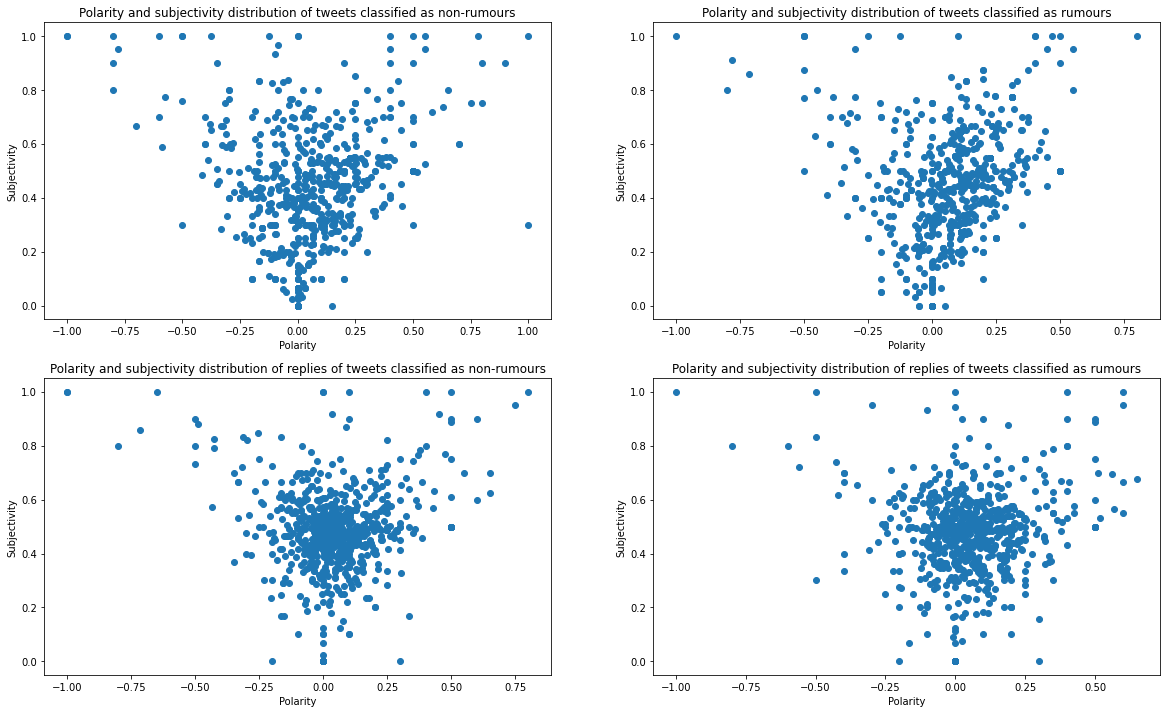

In [18]:
fig = plt.figure(figsize=(20, 12))
fig.tight_layout()

plt.subplot(2, 2, 1)
plt.scatter(non_rumour['tweet sentiment'].sample(1000, random_state=np.random.RandomState(SEED)), 
            non_rumour['tweet subjectivity'].sample(1000, random_state=np.random.RandomState(SEED)))
plt.title('Polarity and subjectivity distribution of tweets classified as non-rumours')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

plt.subplot(2, 2, 2)
plt.scatter(rumour['tweet sentiment'].sample(1000, random_state=np.random.RandomState(SEED)), 
            rumour['tweet subjectivity'].sample(1000, random_state=np.random.RandomState(SEED)))

plt.title('Polarity and subjectivity distribution of tweets classified as rumours')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

plt.subplot(2, 2, 3)
plt.scatter(non_rumour['reply sentiment'].sample(1000, random_state=np.random.RandomState(SEED)), 
            non_rumour['reply subjectivity'].sample(1000, random_state=np.random.RandomState(SEED)))
plt.title('Polarity and subjectivity distribution of replies of tweets classified as non-rumours')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

plt.subplot(2, 2, 4)
plt.scatter(rumour['reply sentiment'].sample(1000, random_state=np.random.RandomState(SEED)), 
            rumour['reply subjectivity'].sample(1000, random_state=np.random.RandomState(SEED)))

plt.title('Polarity and subjectivity distribution of replies of tweets classified as rumours')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
fig.show()

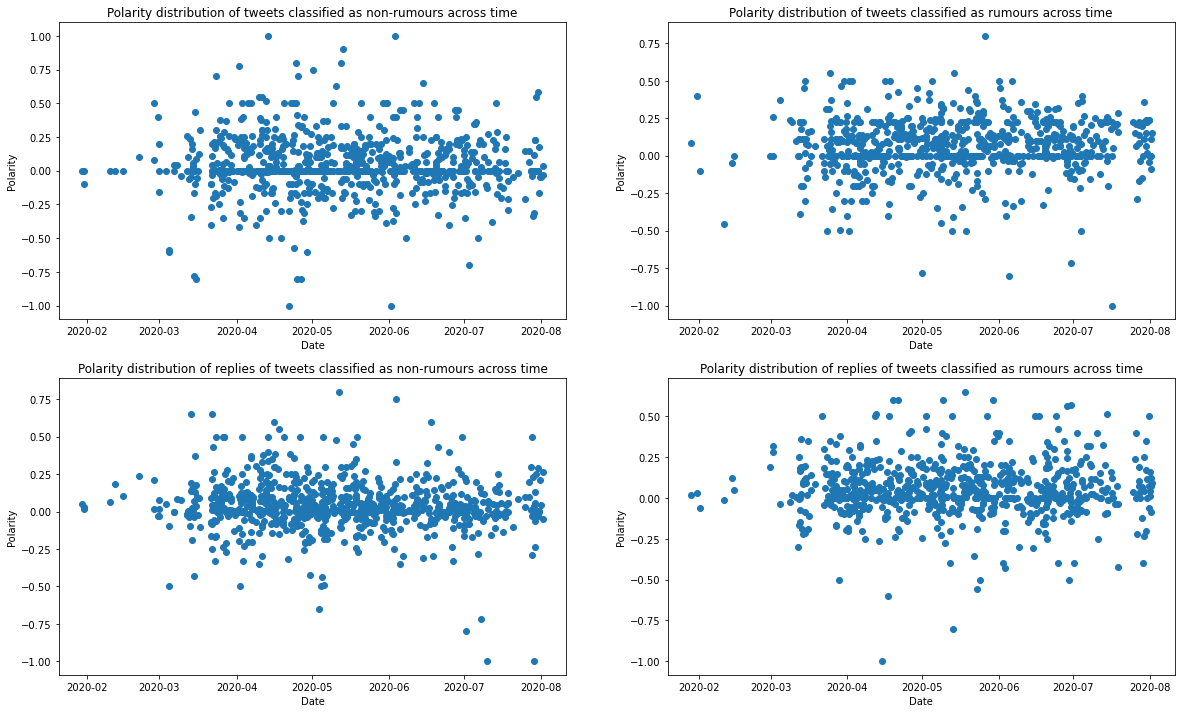

In [19]:
non_rumour['datetime'] = pd.to_datetime(non_rumour['datetime'], format='%y-%m-%d %H:%M:%S')
rumour['datetime'] = pd.to_datetime(rumour['datetime'], format='%y-%m-%d %H:%M:%S')

fig = plt.figure(figsize=(20, 12))
fig.tight_layout()

plt.subplot(2, 2, 1)
plt.scatter(non_rumour['datetime'].sample(1000, random_state=np.random.RandomState(SEED)), 
         non_rumour['tweet sentiment'].sample(1000, random_state=np.random.RandomState(SEED)))
plt.title('Polarity distribution of tweets classified as non-rumours across time')
plt.xlabel('Date')
plt.ylabel('Polarity')

plt.subplot(2, 2, 2)
plt.scatter(rumour['datetime'].sample(1000, random_state=np.random.RandomState(SEED)), 
         rumour['tweet sentiment'].sample(1000, random_state=np.random.RandomState(SEED)))

plt.title('Polarity distribution of tweets classified as rumours across time')
plt.xlabel('Date')
plt.ylabel('Polarity')

plt.subplot(2, 2, 3)
plt.scatter(non_rumour['datetime'].sample(1000, random_state=np.random.RandomState(SEED)), 
         non_rumour['reply sentiment'].sample(1000, random_state=np.random.RandomState(SEED)))
plt.title('Polarity distribution of replies of tweets classified as non-rumours across time')
plt.xlabel('Date')
plt.ylabel('Polarity')

plt.subplot(2, 2, 4)
plt.scatter(rumour['datetime'].sample(1000, random_state=np.random.RandomState(SEED)), 
         rumour['reply sentiment'].sample(1000, random_state=np.random.RandomState(SEED)))

plt.title('Polarity distribution of replies of tweets classified as rumours across time')
plt.xlabel('Date')
plt.ylabel('Polarity')
fig.show()

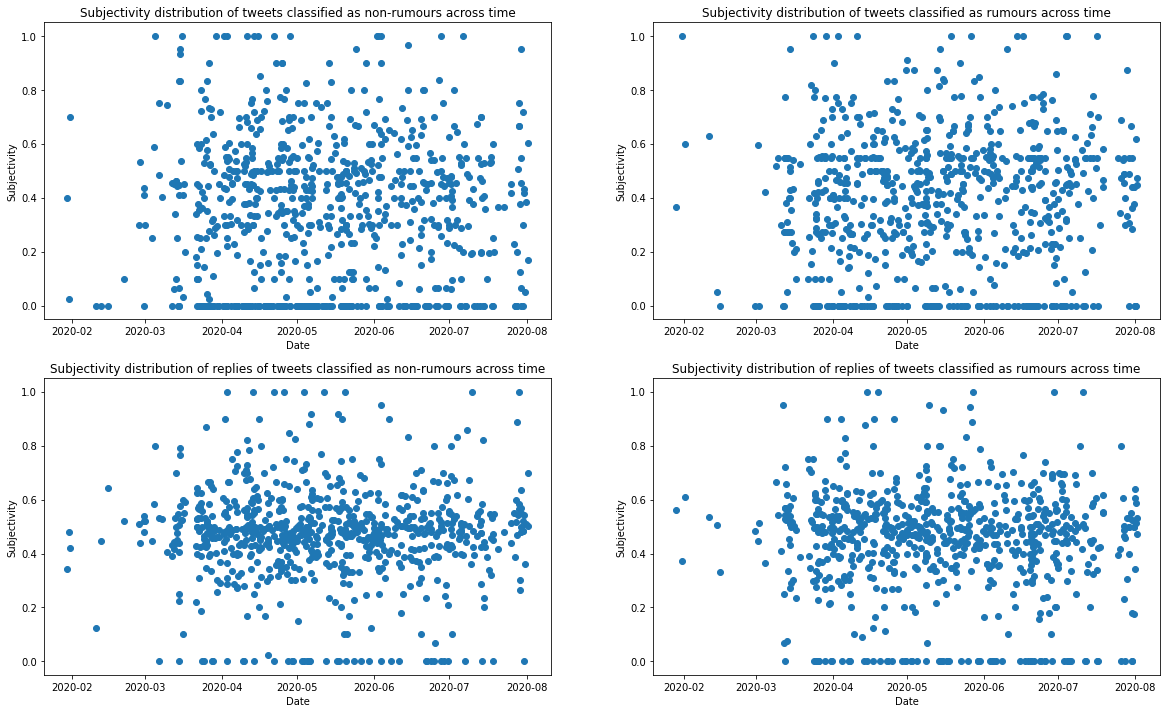

In [20]:
fig = plt.figure(figsize=(20, 12))
fig.tight_layout()

plt.subplot(2, 2, 1)
plt.scatter(non_rumour['datetime'].sample(1000, random_state=np.random.RandomState(SEED)), 
         non_rumour['tweet subjectivity'].sample(1000, random_state=np.random.RandomState(SEED)))
plt.title('Subjectivity distribution of tweets classified as non-rumours across time')
plt.xlabel('Date')
plt.ylabel('Subjectivity')

plt.subplot(2, 2, 2)
plt.scatter(rumour['datetime'].sample(1000, random_state=np.random.RandomState(SEED)), 
         rumour['tweet subjectivity'].sample(1000, random_state=np.random.RandomState(SEED)))

plt.title('Subjectivity distribution of tweets classified as rumours across time')
plt.xlabel('Date')
plt.ylabel('Subjectivity')

plt.subplot(2, 2, 3)
plt.scatter(non_rumour['datetime'].sample(1000, random_state=np.random.RandomState(SEED)), 
         non_rumour['reply subjectivity'].sample(1000, random_state=np.random.RandomState(SEED)))
plt.title('Subjectivity distribution of replies of tweets classified as non-rumours across time')
plt.xlabel('Date')
plt.ylabel('Subjectivity')

plt.subplot(2, 2, 4)
plt.scatter(rumour['datetime'].sample(1000, random_state=np.random.RandomState(SEED)), 
         rumour['reply subjectivity'].sample(1000, random_state=np.random.RandomState(SEED)))

plt.title('Subjectivity distribution of replies of tweets classified as rumours across time')
plt.xlabel('Date')
plt.ylabel('Subjectivity')
fig.show()

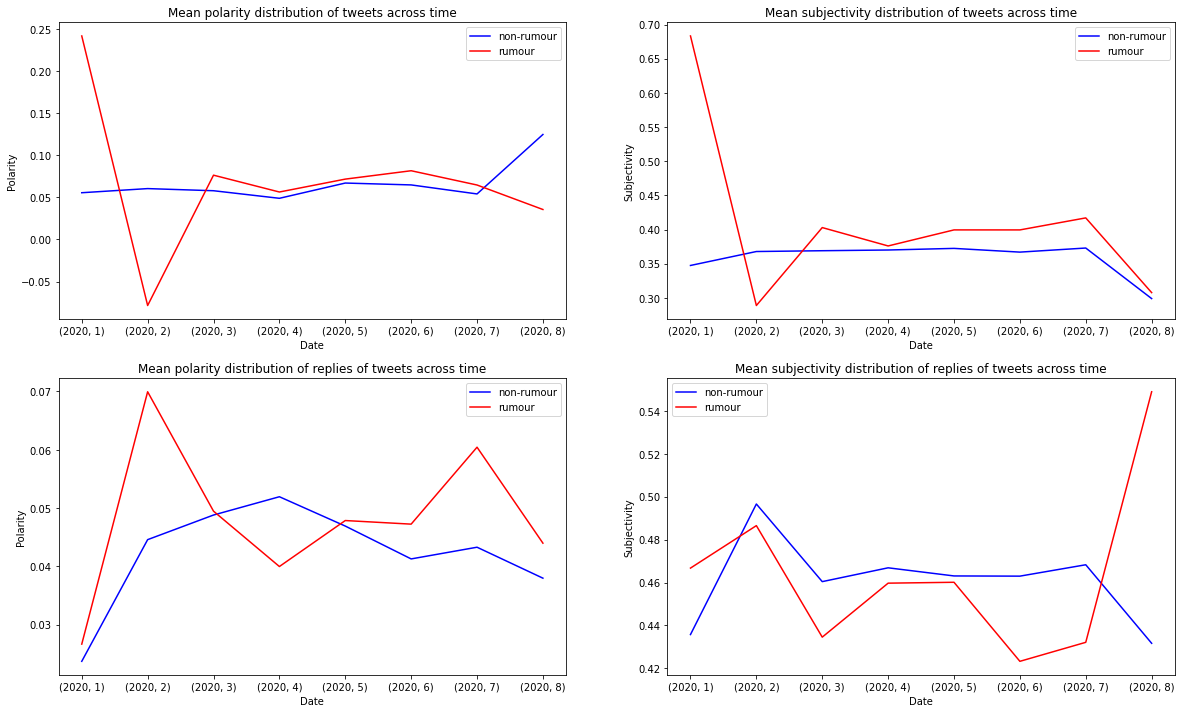

In [21]:
nrT = non_rumour['datetime']
rT = rumour['datetime']

fig = plt.figure(figsize=(20, 12))
fig.tight_layout()

plt.subplot(2, 2, 1)
non_rumour['tweet sentiment'].groupby([nrT.dt.year, nrT.dt.month]).mean().plot(kind="line", color='b', label='non-rumour')
rumour['tweet sentiment'].groupby([rT.dt.year, rT.dt.month]).mean().plot(kind="line", color='r', label='rumour')
plt.title('Mean polarity distribution of tweets across time')
plt.xlabel('Date')
plt.ylabel('Polarity')
plt.legend()

plt.subplot(2, 2, 2)
non_rumour['tweet subjectivity'].groupby([nrT.dt.year, nrT.dt.month]).mean().plot(kind="line", color='b', label='non-rumour')
rumour['tweet subjectivity'].groupby([rT.dt.year, rT.dt.month]).mean().plot(kind="line", color='r', label='rumour')
plt.title('Mean subjectivity distribution of tweets across time')
plt.xlabel('Date')
plt.ylabel('Subjectivity')
plt.legend()

plt.subplot(2, 2, 3)
non_rumour['reply sentiment'].groupby([nrT.dt.year, nrT.dt.month]).mean().plot(kind="line", color='b', label='non-rumour')
rumour['reply sentiment'].groupby([rT.dt.year, rT.dt.month]).mean().plot(kind="line", color='r', label='rumour')
plt.title('Mean polarity distribution of replies of tweets across time')
plt.xlabel('Date')
plt.ylabel('Polarity')
plt.legend()

plt.subplot(2, 2, 4)
non_rumour['reply subjectivity'].groupby([nrT.dt.year, nrT.dt.month]).mean().plot(kind="line", color='b', label='non-rumour')
rumour['reply subjectivity'].groupby([rT.dt.year, rT.dt.month]).mean().plot(kind="line", color='r', label='rumour')
plt.title('Mean subjectivity distribution of replies of tweets across time')
plt.xlabel('Date')
plt.ylabel('Subjectivity')
plt.legend()
fig.show()